<a href="https://colab.research.google.com/github/KettoMisaell/UFC_PREDICTION_NEURAL_NETWORKS/blob/main/PREDICCION_UFC_CON_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICCION DE LOS GANADORES DE COMBATES DE UFC CON REDES NEURONALES**

Se utilizará el módelo XGBoost para decidir el ganador de cada combate de UFC registrado en el Data Set de Kaggle https://www.kaggle.com/datasets/mdabbert/ultimate-ufc-dataset, con 119 características diferentes por cada combate, estadísticas, de antes y después del combate, por supuesto para predecir el ganador solamente se ocuparán características de antes del combate.

Anteriormente se intentó hacer predicciones con un módelo de regresión logística alcanzando un aproximado de 65% de exito en las predicciones tras varias pruebas cambiando las variables predictoras (https://github.com/KettoMisaell/UFC_logistic_prediction/blob/main/UFC_bouts_regresion_logistica.ipynb)

También se realizaron predicciones con un modelo XGBOOST alcanzando cerca de un 66% de exito
https://github.com/KettoMisaell/UFC_PREDICTION_XGBOOST/blob/main/UFC_XGBOOST_PREDICTION.ipynb

Ahora es el turno de poner a pruebas las redes neuronales. Se hará uso de la librería PyTorch para este fin.


# **Carga y procesamiento de datos**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
df = pd.read_csv('/content/ufc-master.csv')

In [ ]:
df.head(10)

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,450.0,350.0,700.0,1100.0,550.0,120.0
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,550.0,275.0,275.0,1400.0,600.0,185.0
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,Punch,1.0,1:20,80.0,175.0,900.0,500.0,3500.0,110.0,1100.0
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,165.0,200.0,400.0,1200.0,900.0,600.0
5,Antonina Shevchenko,Casey O'Neill,215.0,-265,215.000000,37.735849,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,Punches,2.0,4:47,587.0,300.0,200.0,1600.0,330.0,1000.0,300.0
6,Bethe Correia,Karol Rosa,500.0,-720,500.000000,13.888889,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,700.0,-200.0,2500.0,600.0,1600.0,400.0
7,Devonte Smith,Jamie Mullarkey,-155.0,135,64.516129,135.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,Punches,2.0,2:51,471.0,330.0,450.0,2000.0,900.0,140.0,330.0
8,Douglas Silva de Andrade,Gaetano Pirrello,-280.0,225,35.714286,225.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,Punch,1.0,2:04,124.0,165.0,450.0,1400.0,2000.0,150.0,600.0
9,Stephanie Egger,Shanna Young,-155.0,135,64.516129,135.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,Elbow,2.0,2:22,442.0,140.0,225.0,450.0,900.0,800.0,900.0


Se rellenan los valores nulos

In [ ]:
df.fillna(0, inplace = True)

Se guardan las columnas numericas

In [ ]:
columnas_numericas = [x for x in df.columns if df[x].dtype in ['int64', 'float64']]

Eliminamos variables que parecen no aportar nada al modelo para reducir complejidad.
La selección de caracteristicas con poca importancia se hizo tras un analisis exploratorio mostrado en otro notebook y con un conocimiento cualitativo de las variables.

In [ ]:
elementos_a_eliminar = ['R_odds', 'B_odds','B_draw', 'R_draw', 'no_of_rounds' , 'R_win_by_Decision_Majority', 'R_win_by_Decision_Split', 'B_win_by_Decision_Majority', 'B_win_by_Decision_Split', 'empty_arena', 'constant_1', 'B_match_weightclass_rank', 'R_match_weightclass_rank', "R_Women's Flyweight_rank", "R_Women's Featherweight_rank", "R_Women's Strawweight_rank", "R_Women's Bantamweight_rank", 'R_Heavyweight_rank', 'R_Light Heavyweight_rank', 'R_Middleweight_rank', 'R_Welterweight_rank', 'R_Lightweight_rank', 'R_Featherweight_rank', 'R_Bantamweight_rank', 'R_Flyweight_rank', 'R_Pound-for-Pound_rank', "B_Women's Flyweight_rank", "B_Women's Featherweight_rank", "B_Women's Strawweight_rank", "B_Women's Bantamweight_rank", 'B_Heavyweight_rank', 'B_Light Heavyweight_rank', 'B_Middleweight_rank', 'B_Welterweight_rank', 'B_Lightweight_rank', 'B_Featherweight_rank', 'B_Bantamweight_rank', 'B_Flyweight_rank', 'B_Pound-for-Pound_rank', 'finish_round', 'total_fight_time_secs']

nueva_lista = [x for x in columnas_numericas if x not in elementos_a_eliminar]

# **Analisis de componentes principales**


Se hace un analisis de componentes principales para si es viable reducir aun más la dimensionalidad del modelo

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(
    df[nueva_lista]
)
scaled.T   #Normalizacion de los datos

array([[-0.33971738,  0.90770372,  0.18339469, ..., -0.68020452,
        -0.85708096,  0.54554921],
       [-0.27081826, -0.85505558, -0.65843726, ...,  0.38644872,
         1.22628987, -0.7637685 ],
       [-0.62126175,  1.97847972,  0.67860899, ...,  0.67860899,
        -0.62126175,  0.67860899],
       ...,
       [ 1.08296141,  0.37620718,  0.80025972, ..., -1.17865212,
        -1.17865212, -1.17865212],
       [-1.21532047,  0.34504283,  0.46325217, ..., -0.95525992,
        -0.95525992, -0.95525992],
       [-0.68313569, -0.79635368, -0.6625506 , ..., -1.04337475,
        -1.04337475, -1.04337475]])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20) #PCA y su paramentro (se quiere reducir a veinte componentes)
pca.fit(scaled) #Se ajusta a los datos escalados previamente

PCA(n_components=20)

In [ ]:
pca.explained_variance_ratio_

array([0.14800036, 0.10163525, 0.08545883, 0.06357606, 0.04541412,
       0.04098947, 0.03905772, 0.03324151, 0.03221851, 0.02964421,
       0.02780235, 0.02486135, 0.02277764, 0.02223273, 0.02057599,
       0.01976453, 0.01710642, 0.01636173, 0.01476216, 0.01461839])

Se puede ver que no es buena idea reducir más variables pues probablemente se perderá información

# Separación del target y caractericticas

In [ ]:
df['Winner'] = np.where(df['Winner'] == 'Red', 1, 0)

In [ ]:
X = df[nueva_lista]
y = df['Winner']

# Busqueda de correlaciones fuertes

A pesar de que dediqué un ejercicio aparte al analisis exploratorio de mis datos, me parece interesante mostrar acá si hay alguna correlación fuerte entre mis variables y que significa, a pesar de que mi PCA previamente realizado sugiere que no

In [ ]:
matriz = X.corr()
# Se filtraran las correlaciones mayores a .8 o las correlaciones inversas menores a -.8
correlaciones_fuertes = matriz[(matriz > 0.8) | (matriz < -0.8)]


In [ ]:
correlaciones_fuertes.fillna(0, inplace = True )

Se crea un Data Frame nuevo con las correlaciones filtradas y sus repectivas columnas y filas a la que pertenece

In [ ]:
# Tambien se elimina la diagonal principal
posiciones_no_cero = np.where((correlaciones_fuertes != 0) & (correlaciones_fuertes != 1))

valores_no_cero = correlaciones_fuertes.values[posiciones_no_cero]
filas_no_cero, columnas_no_cero = posiciones_no_cero

nombres_filas = correlaciones_fuertes.index[filas_no_cero]
nombres_columnas = correlaciones_fuertes.columns[columnas_no_cero]

df_corr = pd.DataFrame({
    'Fila': nombres_filas,
    'Columna': nombres_columnas,
    'Valor': valores_no_cero
})

In [ ]:
df_corr

,Fila,Columna,Valor
0,B_longest_win_streak,B_wins,0.862416
1,B_losses,B_total_rounds_fought,0.863597
2,B_total_rounds_fought,B_losses,0.863597
3,B_total_rounds_fought,B_win_by_Decision_Unanimous,0.806052
4,B_total_rounds_fought,B_wins,0.932986
5,B_win_by_Decision_Unanimous,B_total_rounds_fought,0.806052
6,B_wins,B_longest_win_streak,0.862416
7,B_wins,B_total_rounds_fought,0.932986
8,B_Height_cms,B_Reach_cms,0.872720
9,B_Reach_cms,B_Height_cms,0.872720


22 correlaciones, que en realidad son 11 porque se repiten la mitad porque la fila toma el valor de columna y viceversa, sin embargo no hay mucho que nos de información valiosa de nuestros  datos, por ejemplo la mayor correlacion es entre el peso del peleador de la esquina roja y el peso del peleador de la esquina azul, situación obvia ya que las peleas se realizan por categorías de peso

# Normalización

In [ ]:
from sklearn.preprocessing import StandardScaler

# Se crea el objeto de la clase StandardScaler
scaler = StandardScaler()

# Normaliza cada columna del dataframe por separado
for column in X.columns:
    X[column] = scaler.fit_transform(X[column].values.reshape(-1, 1))

En el ejercicio de XGBOOST referenciado anteriormente explico porque ocupo esta normalización

# Separación de la data de entrenamiento y test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

En el caso de la división probé con distintos tamaños de entrenamiento y con el que obtuve mejores resultados es 70% de data de entrenamiento y 30% de test.

# Arquitectura del modelo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class FighterPredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FighterPredictionModel, self).__init__()

        # Capa de entrada
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        # Capas ocultas (puedes ajustar el número y el tamaño)
        self.hidden_layer1 = nn.Linear(hidden_dim, 50)
        self.hidden_layer2 = nn.Linear(50, 45)
        self.hidden_layer3 = nn.Linear(45, 30)
        #self.hidden_layer4 = nn.Linear(30, 20)

        # Capa de salida
        self.output_layer = nn.Linear(30, output_dim)

        # Función de activación
        self.sigmoid = nn.Sigmoid()
        self.LogSig = nn.LogSigmoid()
        self.Tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, x):
        # Propagación hacia adelante
        x = self.input_layer(x)
        x = self.LogSig(x)

        x = self.hidden_layer1(x)
        x = self.LogSig(x)

        x = self.hidden_layer2(x)
        x = self.LogSig(x)

        x = self.hidden_layer3(x)
        x = self.Tanh(x)

        #x = self.hidden_layer4(x)
        #x= self.Tanh(x)

        x = self.output_layer(x)
        x = self.sigmoid(x)

        return x

# Definición de hiperparámetros
input_dim = 63  # Número de características de entrada
hidden_dim = 60  # Tamaño de las capas ocultas
output_dim = 1  # Un valor de salida para la clasificación binaria (ganar o perder)

# Crear una instancia del modelo
model = FighterPredictionModel(input_dim, hidden_dim, output_dim)

# Función de pérdida y optimizador
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

print(model)


FighterPredictionModel(
  (input_layer): Linear(in_features=63, out_features=60, bias=True)
  (hidden_layer1): Linear(in_features=60, out_features=50, bias=True)
  (hidden_layer2): Linear(in_features=50, out_features=45, bias=True)
  (hidden_layer3): Linear(in_features=45, out_features=30, bias=True)
  (output_layer): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (LogSig): LogSigmoid()
  (Tanh): Tanh()
  (relu): ReLU()
)


# Conversión de los datos a tensores

In [ ]:
X_train = X_train.values

X_test = X_test.values

# Se convierten los datos en tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Entrenamiento

In [ ]:
torch.manual_seed(42)

#cuántas veces el modelo pasará por los datos de entrenamiento
epocas = 1500


entrenamiento_loss = []
test_loss = []

for epoca in range(epocas):


    #modelo en modo entrenamiento
    model.train()

    # 1. Pase hacia adelante los datos usando el método forward()
    y_predc = model(X_train)

    # 2. Calcula la pérdida
    perdida = criterion(y_predc, y_train)

    # 3. Gradiente cero del optomizador
    optimizer.zero_grad()

    # 4. Pérdida al revés
    perdida.backward()

    # 5. Progreso del optimizador
    optimizer.step()

    ### Función de prueba


    model.eval()

    with torch.inference_mode():


      prueba_predc = model(X_test)

      # 2. Calcular la pérdida en datos de prueba
      prueb_perd = criterion(prueba_predc, y_test.type(torch.float))


      if epoca % 50 == 0:
        entrenamiento_loss.append(perdida.detach().numpy())
        test_loss.append(prueb_perd.detach().numpy())
        print(f"Epoca: {epoca} | Entrenamiento pérdida: {perdida} | Test pérdida {prueb_perd}")

Epoca: 0 | Entrenamiento pérdida: 0.5022751092910767 | Test pérdida 0.5005347728729248
Epoca: 50 | Entrenamiento pérdida: 0.4354635179042816 | Test pérdida 0.4324224889278412
Epoca: 100 | Entrenamiento pérdida: 0.4229806065559387 | Test pérdida 0.4199957847595215
Epoca: 150 | Entrenamiento pérdida: 0.42061561346054077 | Test pérdida 0.41759759187698364
Epoca: 200 | Entrenamiento pérdida: 0.4197842478752136 | Test pérdida 0.4167408049106598
Epoca: 250 | Entrenamiento pérdida: 0.4192641079425812 | Test pérdida 0.41620343923568726
Epoca: 300 | Entrenamiento pérdida: 0.41888460516929626 | Test pérdida 0.41581130027770996
Epoca: 350 | Entrenamiento pérdida: 0.4185900390148163 | Test pérdida 0.4155065715312958
Epoca: 400 | Entrenamiento pérdida: 0.4183521270751953 | Test pérdida 0.41525983810424805
Epoca: 450 | Entrenamiento pérdida: 0.4181528687477112 | Test pérdida 0.4150521457195282
Epoca: 500 | Entrenamiento pérdida: 0.4179782569408417 | Test pérdida 0.41486868262290955
Epoca: 550 | Entr

Visualización de la perdida entrenamiento y de test

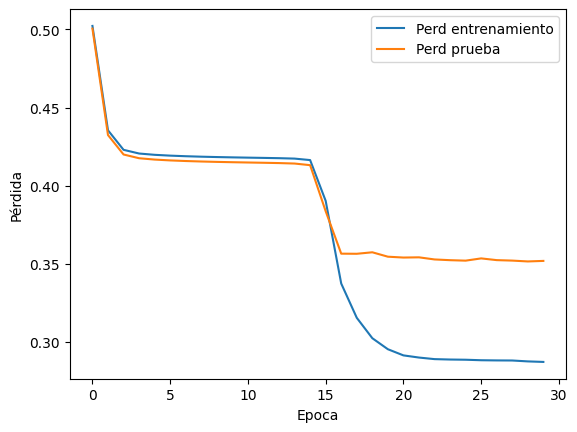

In [ ]:
# Traza las curvas de pérdida
plt.plot(entrenamiento_loss, label="Perd entrenamiento")
plt.plot(test_loss, label="Perd prueba")
plt.ylabel("Pérdida")
plt.xlabel("Epoca")
plt.legend()

# Evaluación

In [ ]:
# 1. Configura el modelo en modo de evaluación
model.eval()

# 2. Configura el administrador de contexto del modo de inferencia
with torch.inference_mode():

  y_predc = model(X_test)

In [ ]:
# Redondear los valores continuos a valores enteros
y_predc = torch.round(y_predc).to(torch.int)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = y_predc,
            normalize = True
           )
print("")
print(f"El modelo tuvo un porcentaje de precision de : {100*accuracy}%")


El modelo tuvo un porcentaje de precision de : 64.87406398910824%


# Se guarda el modelo

In [ ]:
ruta_modelo = 'mejor_modelo.pth'
torch.save({
    'modelo_estado': model.state_dict(),
    'optimizador_estado': optimizer.state_dict(),
    'criterio_estado': criterion.state_dict(),
}, ruta_modelo)

Al obtener resultados bastantes similares con los tres modelos, es coherente pensar que la naturaleza misma de los datos muy probablemente no nos permitirá hacer mucho mejores predicciones, los deportes de combate al igual que la mayoría de competencias deportivas, están sometidas a un número enorme de varibles que no pueden ser recolectadas en un DataSet, variables que implican las emociones humanas o factores externos sometidos al azar, sin embargo, es emocionante crear modelos que puedan aproximar estos resultados.